In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spks import *

%matplotlib widget

In [2]:
binary_path = Path('/home/data/GRB006/20240429_174359/ephys_g0/ephys_g0_imec0/ephys_g0_t0.imec0.ap.bin')
kilosort_path = Path('/home/data/GRB006/20240429_174359/kilosort2.5/imec0/')

In [44]:
raw_data = RawRecording([binary_path],return_preprocessed=False)

In [4]:
clu = Clusters(kilosort_path,get_waveforms=True,get_metrics=True,load_template_features=True)

[Clusters] Computing mean waveforms: 100%|█████████▉| 1083/1088 [01:12<00:00, 14.88it/s]


"Unable to open object (object '1261' doesn't exist)"
[Clusters] - Waveforms file [cluster_waveforms.hdf] not in folder. Use the .extract_waveforms(rawdata) method.


In [15]:
clu.cluster_info

,cluster_id,isi_contamination,firing_rate,presence_ratio,amplitude_cutoff,depth,electrode,shank,trough_time,trough_amplitude,fw3m,trough_gradient,peak_gradient,peak_time,peak_amplitude,spike_duration,polarity,n_active_channels,active_channels
0,0,0.160453,3.361094,1.00,0.500000,3056.513601,0,0,0.003169,-76.338954,0.195355,300.796902,22.183345,0.595235,21.397965,0.592067,-1,20,[ 0 1 2 3 4 5 6 8 179 180 181 1...
1,2,NaN,2.865344,0.86,0.124731,3131.811287,1,0,0.149852,-123.186841,0.415380,-0.076231,214.102380,1.449998,28.467085,1.300146,-1,288,[ 0 1 2 3 4 5 6 7 8 9 10 ...
2,4,NaN,4.397314,0.85,0.000520,3130.875112,141,1,0.124516,128.652046,0.244694,-619.353687,87.002118,0.124516,128.652046,NaN,1,315,[ 0 1 2 3 4 5 6 7 8 9 10 ...
3,5,0.130397,3.107188,1.00,0.500000,3061.817930,1,0,-0.020834,-66.857853,0.230693,161.447431,76.219097,0.582901,21.474642,0.603735,-1,21,[ 0 1 2 3 4 5 6 7 8 9 11 1...
4,6,NaN,1.851485,0.84,0.018290,3137.055670,1,0,0.006836,182.015954,0.338038,-275.015886,-379.445802,0.006836,182.015954,NaN,1,350,[ 0 1 2 3 4 5 6 7 8 9 10 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,1253,NaN,0.225367,0.82,0.500000,3135.439985,96,0,-0.032168,-200.227408,0.030670,-4333.826794,17.631946,0.027505,123.925876,0.059673,-1,383,[ 0 1 2 3 4 5 6 7 8 9 10 ...
1081,1254,0.000000,0.073259,0.53,0.500000,3135.868575,127,1,0.068176,-257.430856,0.029670,-1684.351181,87.964052,0.112848,17.291538,0.044672,-1,383,[ 0 1 2 3 4 5 6 7 8 9 10 ...
1082,1255,NaN,0.226250,0.74,0.500000,3127.726365,135,1,0.149852,-126.296158,0.247028,865.999866,-214.579270,0.490890,98.492809,0.341038,-1,314,[ 0 1 2 3 5 6 7 8 9 11 13 ...
1083,1256,NaN,0.172703,0.62,0.318414,3150.537775,148,1,-0.012166,-117.095513,0.270030,314.135582,21.653092,0.919272,38.357426,0.931438,-1,107,[ 1 9 11 17 22 25 37 39 40 41 46 ...


In [5]:
single_units = clu.cluster_info[
    (np.abs(clu.cluster_info.trough_amplitude - clu.cluster_info.peak_amplitude) > 50) 
    & (clu.cluster_info.amplitude_cutoff < 0.1) 
    & (clu.cluster_info.isi_contamination < 0.1)
    & (clu.cluster_info.presence_ratio >= 0.6)
    & (clu.cluster_info.spike_duration > 0.1)
]

single_units

,cluster_id,isi_contamination,firing_rate,presence_ratio,amplitude_cutoff,depth,electrode,shank,trough_time,trough_amplitude,fw3m,trough_gradient,peak_gradient,peak_time,peak_amplitude,spike_duration,polarity,n_active_channels,active_channels
7,9,0.044686,2.996563,1.00,0.001258,3021.984305,4,0,-0.008499,-186.641194,0.138016,772.103826,49.512405,0.540563,59.570190,0.549062,-1,18,[ 0 1 2 3 4 5 6 7 8 9 10 ...
10,12,0.005187,10.664353,1.00,0.000299,3012.624467,6,0,-0.018167,-283.029087,0.151684,1092.945694,87.778160,0.527561,78.624795,0.545728,-1,25,[ 0 1 2 3 4 5 6 7 8 9 10 ...
12,14,0.076110,8.889952,1.00,0.046270,3034.990903,10,0,0.004169,-113.043799,0.166685,434.947985,72.627625,0.615238,31.517739,0.611069,-1,22,[ 0 1 2 3 4 5 6 7 8 9 10 ...
13,15,0.041626,2.193655,0.84,0.023025,3138.852612,148,1,-0.144181,-23.890192,0.805090,78.733272,81.418490,0.877267,110.067257,1.021448,-1,206,[ 0 1 2 3 5 7 8 9 11 14 16 ...
21,24,0.001039,19.431324,1.00,0.000320,3038.153537,12,0,-0.007832,-243.392785,0.174020,826.873548,75.688038,0.530895,65.616785,0.538727,-1,23,[ 2 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,1241,0.000000,1.308367,1.00,0.088613,3176.088664,284,3,0.006169,-104.069414,0.157351,476.057249,50.237386,0.613571,28.393605,0.607402,-1,6,[280 282 284 286 336 338]
1070,1243,0.068856,2.103626,1.00,0.014943,3212.660428,294,2,-0.006165,-133.945985,0.148683,521.620284,88.431815,0.528561,41.212143,0.534727,-1,10,[288 289 290 291 292 293 294 295 296 298]
1073,1246,0.000000,0.289212,0.98,0.000263,3268.720812,323,2,-0.003832,-185.678649,0.146016,759.972752,226.636034,0.638907,45.074075,0.642739,-1,8,[305 307 315 317 319 321 323 324]
1078,1251,0.055284,6.040495,1.00,0.000746,3041.660801,373,2,-0.018167,-118.063276,0.159685,508.317630,122.087282,0.835596,25.182284,0.853763,-1,8,[373 374 375 376 377 378 379 380]


In [ ]:
def plot_cluster_info_histograms(clu):
    # Setup
    fig, axs = plt.subplots(3, 2, tight_layout=True, figsize=(10, 6))
    n_bins = 50

    # Calculate the total number of neurons
    total_neurons = len(clu.cluster_info)

    # Calculate the excluded samples
    excluded_peak_amplitude = np.sum(np.abs(clu.cluster_info.trough_amplitude - clu.cluster_info.peak_amplitude) <= 50)
    excluded_isi_contamination = np.sum(clu.cluster_info.isi_contamination > 0.1)
    excluded_spike_duration = np.sum(clu.cluster_info.spike_duration <= 0.1)
    excluded_presence_ratio = np.sum(clu.cluster_info.presence_ratio <= 0.6)
    excluded_amplitude_cutoff = np.sum(clu.cluster_info.amplitude_cutoff > 0.1)

    # Set the figure title
    fig.suptitle(f'Total clusters: {total_neurons}\n Shaded area indicates excluded clusters by metric', fontsize=14)

    # ------- Plot histograms ------- #

    # spike amplitude
    axs[0, 0].hist(np.abs(clu.cluster_info.trough_amplitude - clu.cluster_info.peak_amplitude), bins=n_bins, alpha=0.5, color='b')
    axs[0, 0].axvline(x=50, color='b', linestyle='--')
    axs[0, 0].fill_betweenx(y=axs[0, 0].get_ylim(), x1=max(axs[0, 0].get_xlim()[0], 0), x2=50, color='b', alpha=0.1)
    axs[0, 0].set_xlabel('spike amplitude')
    axs[0, 0].set_ylabel('counts')
    axs[0, 0].set_title(f'n = {excluded_peak_amplitude}')

    # ISI contamination
    axs[1, 0].hist(clu.cluster_info.isi_contamination, bins=n_bins, alpha=0.5, color='g')
    axs[1, 0].axvline(x=0.1, color='g', linestyle='--')
    axs[1, 0].fill_betweenx(y=axs[1, 0].get_ylim(), x1=0.1, x2=min(axs[1, 0].get_xlim()[1], axs[1, 0].get_xlim()[1]), color='g', alpha=0.1)
    axs[1, 0].set_xlabel('isi_contamination')
    axs[1, 0].set_ylabel('counts')
    axs[1, 0].set_title(f'n = {excluded_isi_contamination}')

    # spike duration
    axs[2, 0].hist(clu.cluster_info.spike_duration, bins=n_bins, alpha=0.5, color='r')
    axs[2, 0].axvline(x=0.1, color='r', linestyle='--')
    axs[2, 0].fill_betweenx(y=axs[2, 0].get_ylim(), x1=max(axs[2, 0].get_xlim()[0], 0), x2=0.1, color='r', alpha=0.1)
    axs[2, 0].set_xlabel('spike_duration')
    axs[2, 0].set_ylabel('counts')
    axs[2, 0].set_title(f'n = {excluded_spike_duration}')

    # presence ratio
    axs[0, 1].hist(clu.cluster_info.presence_ratio, bins=n_bins, alpha=0.5, color='orange')
    axs[0, 1].axvline(x=0.6, color='orange', linestyle='--')
    axs[0, 1].fill_betweenx(y=axs[0, 1].get_ylim(), x1=max(axs[0, 1].get_xlim()[0], 0), x2=0.6, color='orange', alpha=0.1)
    axs[0, 1].set_xlabel('presence_ratio')
    axs[0, 1].set_ylabel('counts')
    axs[0, 1].set_title(f'n = {excluded_presence_ratio}')

    # amplitude cutoff
    axs[1, 1].hist(clu.cluster_info.amplitude_cutoff, bins=n_bins, alpha=0.5, color='purple')
    axs[1, 1].axvline(x=0.1, color='purple', linestyle='--')
    axs[1, 1].fill_betweenx(y=axs[1, 1].get_ylim(), x1=0.1, x2=min(axs[1, 1].get_xlim()[1], axs[1, 1].get_xlim()[1]), color='purple', alpha=0.1)
    axs[1, 1].set_xlabel('amplitude_cutoff')
    axs[1, 1].set_ylabel('counts')
    axs[1, 1].set_title(f'n = {excluded_amplitude_cutoff}')

    # depth - not used for filtering out clusters, but a helpful viz nonetheless
    axs[2, 1].hist(clu.cluster_info.depth, bins=n_bins, alpha=0.5, color='c')
    axs[2, 1].set_xlabel('depth')
    axs[2, 1].set_ylabel('counts')


plot_cluster_info_histograms(clu)

In [16]:
# ---------- this gets the row indices ---------- #
single_unit_idx = np.where((np.abs(clu.cluster_info.trough_amplitude - clu.cluster_info.peak_amplitude) > 50)
            & (clu.cluster_info.amplitude_cutoff < 0.1) 
            & (clu.cluster_info.isi_contamination < 0.1)
            & (clu.cluster_info.presence_ratio >= 0.6)
            & (clu.cluster_info.spike_duration > 0.1))[0]

# ---------- and this get the cluster_id values ---------- #
mask = ((np.abs(clu.cluster_info.trough_amplitude - clu.cluster_info.peak_amplitude) > 50)
            & (clu.cluster_info.amplitude_cutoff < 0.1) 
            & (clu.cluster_info.isi_contamination < 0.1)
            & (clu.cluster_info.presence_ratio >= 0.6)
            & (clu.cluster_info.spike_duration > 0.1))


single_unit_ids = clu.cluster_info[mask].cluster_id.values

# single_unit_ids

In [ ]:
# import spks.io as sio

# clusters = sio.load_cluster_data(kilosort_path)

In [22]:
single_unit_idx[single_unit_idx!=1084]

array([   7,   10,   12,   13,   21,   22,   24,   26,   29,   30,   31,
         35,   40,   42,   49,   54,   55,   56,   61,   74,   83,   96,
         99,  103,  104,  105,  106,  110,  111,  121,  122,  123,  124,
        125,  137,  142,  143,  147,  151,  153,  155,  158,  161,  163,
        164,  171,  184,  188,  198,  200,  209,  213,  236,  256,  274,
        276,  283,  285,  299,  300,  319,  323,  336,  339,  342,  346,
        348,  354,  358,  360,  369,  370,  374,  378,  403,  404,  419,
        423,  424,  426,  429,  437,  438,  439,  441,  443,  445,  449,
        450,  451,  456,  461,  464,  465,  472,  475,  477,  485,  489,
        490,  493,  494,  498,  499,  500,  505,  507,  511,  515,  518,
        524,  526,  528,  531,  534,  535,  548,  552,  555,  558,  560,
        562,  565,  573,  574,  577,  578,  580,  581,  583,  586,  587,
        588,  598,  602,  605,  630,  632,  640,  662,  668,  669,  675,
        677,  697,  701,  705,  718,  724,  727,  7

In [18]:
good_spikes = clu.spike_times[np.isin(clu.spike_clusters,single_unit_idx)] 
good_clusters = clu.spike_clusters[np.isin(clu.spike_clusters,single_unit_idx)]  

assert good_spikes.shape == good_clusters.shape

In [ ]:
# CLUSTER_ID = 9
# good_spikes = good_spikes[good_clusters == CLUSTER_ID] # only get spikes from one cluster
# print(f'We will extract {len(good_spikes)} spikes for this cluster')

# # good_spikes = np.hstack((good_spikes + 30000, good_spikes + np.max(good_spikes) - 30000))
# print(good_spikes.shape)

In [ ]:
# import spks.waveforms as spwaves

# SCRATCH_DIR = '/scratch/GRB' # fast disk to write memmap file
# nchannels = raw_data.shape[1]

# waves = spwaves.extract_memmapped_waveforms(raw_data, SCRATCH_DIR, good_spikes[:100])
# waves.shape # (nspikes, nsamples, nchannels)

In [10]:
spike_times = read_phy_data(kilosort_path, srate=1, use_kilosort_results=True)['ts'] #ts = timestamps i think

This session has not been curated or user has forced use of kilosort results. Labels are from KS.


In [46]:
spike_times

0       [9997.0, 15600.0, 32753.0, 32970.0, 39220.0, 5...
1       [698153.0, 714662.0, 715686.0, 716191.0, 71868...
2       [698141.0, 708596.0, 708626.0, 709096.0, 70959...
3       [6722.0, 26797.0, 30008.0, 30446.0, 32035.0, 3...
4       [707636.0, 708103.0, 713148.0, 714147.0, 71510...
                              ...                        
1078    [523833.0, 697887.0, 873417.0, 1052713.0, 1055...
1079    [873419.0, 1249234.0, 1623987.0, 1760149.0, 17...
1080    [757689.0, 849957.0, 1030582.0, 1033331.0, 103...
1081    [709935.0, 712934.0, 714935.0, 729951.0, 73394...
1082    [17910.0, 18840.0, 21440.0, 23587.0, 25459.0, ...
Name: ts, Length: 1083, dtype: object

In [47]:
from spks.phy_utils import read_phy_data
from spks.waveforms import extract_waveform_set

spike_times = read_phy_data(kilosort_path, srate=1, use_kilosort_results=True)['ts'] #ts = timestamps i think
SCRATCH_DIR = '/scratch/GRB/temp_waves' # fast disk to write memmap file
nchannels = raw_data.shape[1]

# waves = extract_waveform_set(spike_times, raw_data, max_n_spikes=100)
st = [spike_times[i] for i in single_unit_idx[single_unit_idx!=1084]]
waves = extract_waveform_set(st, raw_data, max_n_spikes=100, mmap_output=True, scratch_directory=SCRATCH_DIR)

This session has not been curated or user has forced use of kilosort results. Labels are from KS.


Extracting waveforms: 100%|██████████| 230/230 [01:16<00:00,  3.00it/s]
Exception ignored in: <function TemporaryArrayOnDisk.__del__ at 0x7f42c116d4e0>
Traceback (most recent call last):
  File "/home/joao/lib/spks/spks/utils.py", line 54, in __del__
    os.remove(self.filename)
FileNotFoundError: [Errno 2] No such file or directory: '/scratch/GRB/anrDfLypKwjJUUsgdUQV.bin'
Exception ignored in: <function TemporaryArrayOnDisk.__del__ at 0x7f42c116d4e0>
Traceback (most recent call last):
  File "/home/joao/lib/spks/spks/utils.py", line 54, in __del__
    os.remove(self.filename)
FileNotFoundError: [Errno 2] No such file or directory: '/scratch/GRB/VzOhPeEyKYwOrvFGSoXA.bin'
Exception ignored in: <function TemporaryArrayOnDisk.__del__ at 0x7f42c116d4e0>
Traceback (most recent call last):
  File "/home/joao/lib/spks/spks/utils.py", line 54, in __del__
    os.remove(self.filename)
FileNotFoundError: [Errno 2] No such file or directory: '/scratch/GRB/dXRFPsfbWWCMujHuUcCV.bin'
Exception ignore

interactive(children=(IntSlider(value=0, description='clu_idx', max=229), Output()), _dom_classes=('widget-int…

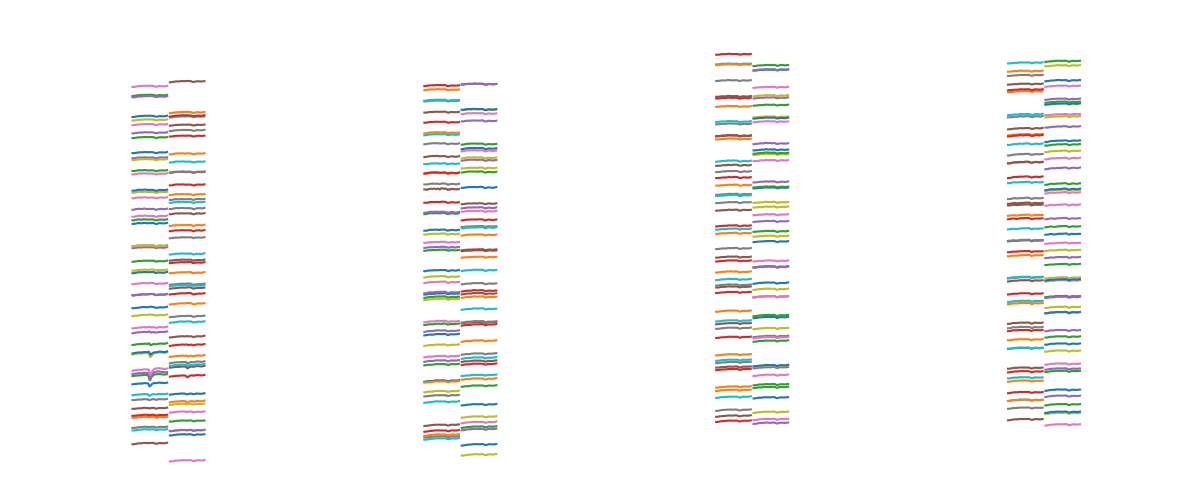

In [48]:
from ipywidgets import interact, IntSlider
from spks.viz import plot_footprints

fig, ax = plt.subplots(1, 1, figsize=(12, 5))

@interact(clu_idx=IntSlider(min=0, max=len(waves)-1, step=1, value=0))
def g(clu_idx):
    ax.clear()

    channel_xy = raw_data.metadata[0]['coords']
    channel_idx = raw_data.metadata[0]['channel_idx']
    plot_footprints(np.mean(waves[clu_idx][:,:,channel_idx], axis=0), channel_xy, shade_color='k')

    return

In [ ]:
# weird clusters: 48, 79, 81, 83, 90, 91, 113, 115... there's actually a bunch of them

In [55]:
single_unit_ids

array([   9,   12,   14,   15,   24,   25,   27,   29,   37,   40,   41,
         46,   51,   53,   61,   66,   67,   68,   75,   92,  103,  122,
        126,  130,  131,  132,  133,  138,  139,  149,  150,  151,  152,
        153,  170,  176,  177,  182,  186,  188,  190,  193,  196,  198,
        199,  208,  222,  227,  238,  240,  255,  259,  289,  317,  336,
        339,  348,  350,  368,  369,  398,  402,  415,  418,  421,  425,
        427,  434,  438,  440,  451,  452,  457,  463,  499,  500,  517,
        522,  523,  526,  529,  541,  543,  544,  546,  549,  552,  557,
        558,  559,  564,  569,  573,  574,  582,  585,  587,  596,  602,
        603,  606,  607,  611,  612,  613,  620,  622,  626,  630,  633,
        639,  641,  643,  652,  655,  656,  675,  680,  685,  690,  692,
        694,  697,  709,  710,  714,  715,  717,  718,  720,  724,  725,
        726,  739,  743,  746,  780,  782,  790,  816,  823,  824,  830,
        832,  853,  857,  861,  881,  887,  890,  8

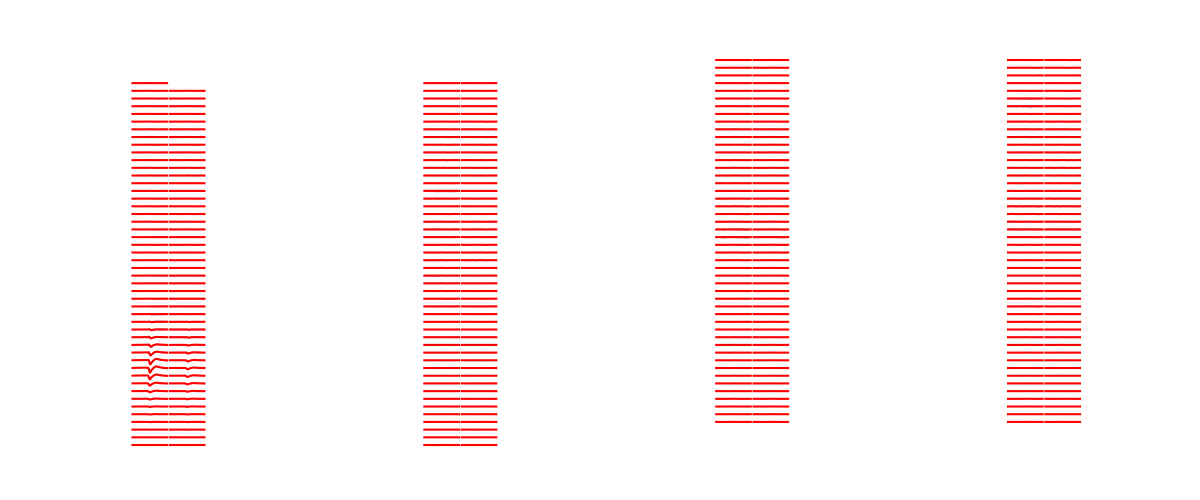

In [57]:
plt.figure(figsize=[12,5])
# plot the cluster waveforms accross all channels and overlay with the standard deviation
plot_footprints(clu.cluster_waveforms_mean[clu.cluster_id == 9],clu.channel_positions,
                shade_data = clu.cluster_waveforms_std[clu.cluster_id == 9].squeeze(), color='r');
# plt.axis((720, 805., 1407, 1677));

In [76]:
clu2 = Clusters(kilosort_path,get_waveforms=False,get_metrics=False,load_template_features=False)
# Extract the waveforms as save them to clu.folder 'cluster_waveforms.hdf' file
waveforms = clu2.extract_waveforms(raw_data,max_n_spikes = 1000,save_folder_path = None)
# Filtering is not optimized and might take a while, depending on the recording. 
# This will also compute the mean waveform.

# %matplotlib notebook
plt.figure(figsize=[3,5])
# plot the cluster waveforms accross all channels and overlay with the standard deviation
plot_footprints(clu2.cluster_waveforms_mean[clu.cluster_id == 9],clu2.channel_positions,
                shade_data = clu2.cluster_waveforms_std[clu.cluster_id == 9].squeeze(), color='r');
# plt.axis((720, 805., 1407, 1677));

Filtering waveforms:  61%|██████    | 666/1088 [49:13<1:01:40,  8.77s/it]

KeyboardInterrupt: 

In [ ]:
# if needed
# compute metrics to estimate the location of the spikes
clu2.compute_statistics()
# # update the object so indexing includes the new metrics
clu2.update_cluster_info()

'[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17\n  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35\n  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53\n  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71\n  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89\n  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107\n 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125\n 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143\n 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161\n 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179\n 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197\n 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215\n 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233\n 234 235 236 237 238 239 240 241 242 

In [ ]:
# plot the principal channels for a set of clusters
# %matplotlib notebook
# plot some of the high amplitude clusters
clusters2 = clu2.cluster_id[np.argsort(clu2.trough_amplitude)[:5]]
for iclu,c in zip(clusters2,['#d62728',
                            '#1f77b4',
                            '#ff7f0e',
                            '#2ca02c',
                            '#9467bd']):
    
    idx = clu2.active_channels[clu2.cluster_id == iclu][0]
    plot_footprints(clu2.cluster_waveforms_mean[clu2.cluster_id == iclu].squeeze()[:,idx],clu2.channel_positions[idx,:],
                    color=c);
    
# plt.axis((718, 808, 1718, 2231));

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24